### Image Quality Assessment
-----------------------------------
#### Steps:
**1:** Read in all the images from the server.

**2:** Break the images into smaller categories. This can be accomplished via a K-Means classifier or possibly by running the images through a different CNN beforehand. These categories are then stored and used later. 

**3:** Determine labels based on the metadata stored in the pictures. For many of the 2017 pictures there is exif, IPTC, and XMP. The differences are as follows:

* exif - Stored by camera at the time of the picture. This includes GPS location, pixel count, zoom, etc.
* IPTC - Metadata added via an editor. This is generally an older bulk metadata system. While still used it is getting phased out by XMP.
* XMP - Metadata that can be applied as an "xml"-like file or added in headers and footers of images. It is more clearly defined than IPTC and significantly newer. It also allows for more metadata to be stored. 

For both IPTC and XMP, they contain information we can use as labels. We have preference tags (code 221) where information has been stored determining which pictures have been preferenced before our work began. In addition to this, the Reynolds Journalism School has informed us that they have color classed about half of the images via PhotoMechanic which is stored in the IPTC and XMP data. These color classes correspond to a quality assessment on a rough range of 0-9. Once labels have been determined we can begin training.

**4:** Import VGG-16. This is a very successful pretrained classification model that has shown promise in previous studies attempting similar techniques as us, most notibly NIMA (Neural IMage Assessment) by the perceptron team at Google.AI in 2015.

**5:** Once the pretrained model has been imported we can pull the fully connected component off the top and replace it with our own. Initially we will replace it with one total classifier to determine quality but after proof of concept has been established we can supply two different classifiers (1 for technical assessment and 1 for aesthetics). These classifiers shall be constant for each category of picture while just changing the loaded weights for the system. This allows us to adjust our idea of what quality is based on the category it is in. 

**6:** After the models have provided a technical and aesthetic score we can use the Choquet Integral to aggregate the data together and get a measurement of uncertainty. This shall provide us with a rating and a range both of which can be used to rank photos in a set. 

In [1]:
#standard ML/Image Processing imports
import numpy as np
import pandas as pd
import math, pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

#pytorch imports
import torch
import torch.optim as optim
import torchvision.models as models

from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# no one likes irrelevant warnings
import warnings  
warnings.filterwarnings('ignore')

# root directory where the images are stored
data_dir = "/mnt/md0/mysql-dump-economists/Archives/2017"#/*year*#/Fall"#/Dump"

At this point, we have created all our global variables necessary for the classifier and imported all necessary libraries. Next we need to determine the images under test. Once we have gotten access to GPUs we can scale this up.

The class below extends PyTorch's native ImageFolder class, with an adjustment to store/retrieve file paths. The native ImageFolder class allows us to iterate through and pull all files from inside a home directory.

There is also a function defined below which is just an optional "helper" function to help us get an idea of what our data looks like so that we know what to resize it to (we do not want to make the dimensions of the resize to be bigger than any of the pictures)

In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
#         print(tuple_with_path)
        return tuple_with_path
ratings = None
class ImageFolderWithPathsAndRatings(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPathsAndRatings, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path
        # set rating
        try:
            rating = ratings[index] - 1 if ratings[index] > 0 else ratings[index]
            tuple_with_path_and_rating = (tuple_with_path + (rating,))
        except:
            tuple_with_path_and_rating = (tuple_with_path + (torch.FloatTensor([0]),))
        return tuple_with_path_and_rating

def find_size_bounds(limit_num_pictures=None):
    """ Will print and return min/max width/height of pictures in the dataset 
    :param limit_num_pictures - limits the number of pictures analyzed if you purposefully 
        want to work with a smaller dataset
    """
    data = ImageFolderWithPaths(data_dir)
    print(data[0][0].size)
    max_h = (data[0][0]).size[1]
    min_h = data[0][0].size[1]
    max_w = data[0][0].size[0]
    min_w = data[0][0].size[0]
    try:
        for (i, pic) in enumerate(data):
            #if we are limiting pics
            if limit_num_pictures:
                if i > limit_num_pictures:
                    break
            print(pic[0].size) # print all size dimensions
            
            # check width records
            if pic[0].size[0] > max_w:
                max_w = pic[0].size[0]
            elif pic[0].size[1] < min_w:
                min_w = pic[0].size[0]

            # check height records
            if pic[0].size[1] > max_h:
                max_h = pic[0].size[1]
            elif pic[0].size[1] < min_h:
                min_h = pic[0].size[1]
    except Exception as e:
        print(e)
        print("error occurred on pic {} number {}".format(pic, i))

    print("Max/min width: {} {}".format(max_w, min_w))
    print("Max/min height: {} {}".format(max_h, min_h))
    return min_w, max_w, min_h, max_h
#find_size_bounds(limit_num_pictures=1000)

### Reading and Interpreting Metadata

There is a lot of data stored in each of the images. It is stored in 3 types of metadata extensions. They are:
1. XMP
2. Exif
3. IPTC

Because we mostly care about the color classes and whether images are "tagged" or not we need edited in data. This data is supplied using Photomechanic or Photoshop and looks different to an image. Because Exif is the data the camera collected at the time the picture was taken, this means that this data is stored in the XMP and IPTC data. IPTC (International Press Telecommunications Council) Metadata is an older varient where XMP is newer and can be stored either in a sidecar file or in the image itself. This may make a difference as we work backward in year over our images. But starting in 2017, XMP is easier to work with so we will use it as the baseline. Metadata tags look like the following:

##### Steps to find XMP metadata in image:
1. Read in image via file path
2. Open the image in read binary mode
3. Search the image to find the '<x:xmpmeta' tag and read to the '</x:xmpmeta' closing tag
4. Add padding for last close xmp tag
5. Print out the xmp data

From here the most useful 3 data tags are located near the top. They are:
```
photomechanic:ColorClass="0"
photomechanic:Tagged="False"
photomechanic:Prefs="0:0:0:008714"
```
Where tagged is whether the image is tagged at all, the prefs a base 64 string that contains specially designated preferences, and the final color class is the color code assigned. The color code exists on ~20% of all images in the dataset and spans a range of 1-8.

In [3]:
# load data and apply the transforms on contained pictures

_transform = transforms.Compose([transforms.ToTensor()])

data = ImageFolderWithPaths(data_dir, transform=_transform)

data_loader = torch.utils.data.DataLoader(data)#, num_workers=4)

limit_num_pictures = 5000

rated_indices = []
bad_indices = []
ratings = []

attempts = 5
breaking = False
i = 0
for attempt in range(attempts):
    if breaking:
        break
    print("Attempt #{} starting with i = {}".format(attempt, i))
    try:
        for inputs, label, path in data_loader:
            if limit_num_pictures:
                if i > limit_num_pictures:
                    breaking = True
                    break
            path = path[0].rstrip()
            with open(path, "rb") as f:
                img = f.read()
            img_string = str(img)
            xmp_start = img_string.find('photomechanic:ColorClass')
            xmp_end = img_string.find('photomechanic:Tagged')
            if xmp_start != xmp_end:
                xmp_string = img_string[xmp_start:xmp_end]
                if xmp_string[26] != "0":
                    print(xmp_string[26] + " " + str(path) + "\n\n")
                    rated_indices.append(i)
                    ratings.append(xmp_string[26])
                else:
                    ratings.append(0)
                    bad_indices.append(i)
            i += 1
    except Exception as e:
        print("Error on attempt #{}".format(attempt))
        print("There was an error on image #{}: {}".format(i, e))
        i += 1
print("Num rated: {}, num not rated: {}".format(len(rated_indices), len(bad_indices)))


Attempt #0 starting with i = 0
2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_028.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_043.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_095.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_110.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_113.JPG


1 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_134.JPG


1 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_164.JPG


2 /mnt/md0/mysql-dump-economists/Archives/201

2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0562.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0563.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0564.JPG


1 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0565.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0569.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0574.JPG


4 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0580.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/2017082

1 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_054.JPG


1 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_072.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_075.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_103.JPG


1 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_105.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_147.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_177.JPG


2 /mnt/md0/mysql-dum

2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_221.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_227.JPG


1 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_233.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_272.JPG


2 /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_384.JPG


Num rated: 193, num not rated: 4670


Below we split the data into training and testing sets, perform our defined transform to resize and crop pictures, and define the loaders that will load all the pictures

In [1]:
# define our transforms to apply on each image
_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize( 
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_size = 0.2 # percentage of data to use for test set

# load data and apply the transforms on contained pictures
train_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)
test_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)   

num_pictures = len(train_data)
print("Number of pictures in subdirectories: {}".format(num_pictures))

# Shuffle pictures and split training set
indices = list(range(num_pictures))
print("Head of indices: {}".format(indices[:10]))

# Finding the index of where to split entire set into training and test sets
split = int(np.floor(valid_size * num_pictures))
print("Split index: {}".format(split))

# Shuffle all the images so order does not affect which images are picked for the training/test sets
np.random.shuffle(indices)
print("Head of shuffled indices: {}".format(indices[:10]))

train_idx, test_idx = indices[split:], indices[:split] #rated_indices, bad_indices
print("Size of training set: {}, size of test set: {}".format(len(train_idx), len(test_idx)))

# Define samplers that sample elements randomly without replacement
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define data loaders, which allow batching and shuffling the data
train_loader = torch.utils.data.DataLoader(train_data,
            sampler=train_sampler, batch_size=1)#, num_workers=4)
print("Train loader length: {}".format(len(train_loader)))
test_loader = torch.utils.data.DataLoader(test_data,
            sampler=test_sampler, batch_size=1)#, num_workers=4)
print("Test loader length: {}".format(len(test_loader)))

NameError: name 'transforms' is not defined

#### Download the VGG16 Neural Net

We will now load the VGG16 model from PyTorch's set of pretrained models. 

In [5]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device that will be used: {}".format(device))

# we load the pretrained model, the argument pretrained=True implies to load the ImageNet 
#     weights for the pre-trained model
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device) # loads the model onto the device (CPU or GPU)

Device that will be used: cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Freezing Convolution Weights

One important thing to notice here is that the classifier model is classifying 1000 classes. You can observe the very last Linear block to confirm that. But we need to classify the images into 10 classes only. So, we will change that. Also, we will freeze all the weights of the convolutional blocks. The model as already learned many features from the ImageNet dataset. So, freezing the Conv2d() weights will make the model to use all those pre-trained weights. This is the part that really justifies the term transfer learning.

The following block of code makes the necessary changes for the 10 class classification along with freezing the weights.

#### Building Fully Connected Classifier
After we have VGG-16 set up we need to build and add the fully connected layer to it. That is accomplished below.

In [6]:
for param in vgg16.parameters():
    param.requires_grad = False #freeze all convolution weights
network = list(vgg16.classifier.children())[:-1] #remove fully connected layer
network.extend([nn.Linear(4096, 8)]) #add new layer of 4096->100 (rating scale with 1 decimal - similar to 1 hot encoding)
vgg16.classifier = nn.Sequential(*network)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(vgg16.parameters(), lr=0.4, momentum=0.9) # optimizer

vgg16 #print out the model to ensure our network is correct

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now that we have the new layer added and the rest frozen, we must train the new set with our below code to fit the model

tensor([0])
tensor([[-0.2725, -1.0950,  0.1922,  0.8319,  0.6494,  1.1308,  0.2566,  0.5560]],
       grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #0: tensor([[-0.2725, -1.0950,  0.1922,  0.8319,  0.6494,  1.1308,  0.2566,  0.5560]],
       grad_fn=<AddmmBackward>)



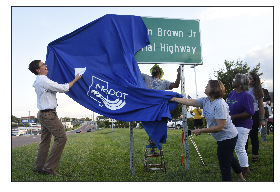

tensor([0])
tensor([[154.8044,  -4.4568, -15.4021, -29.3137, -24.9858, -40.4854, -17.0904,
         -23.1912]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #1: tensor([[154.8044,  -4.4568, -15.4021, -29.3137, -24.9858, -40.4854, -17.0904,
         -23.1912]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[172.5075,  -5.4522, -18.0806, -33.7986, -27.7659, -44.6267, -18.3178,
         -25.1085]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #2: tensor([[172.5075,  -5.4522, -18.0806, -33.7986, -27.7659, -44.6267, -18.3178,
         -25.1085]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 510.5449,  -15.1506,  -51.5925,  -98.3354,  -82.8976, -132.6953,
          -54.5515,  -75.5252]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #3: tensor([[ 510.5449,  -15.1506,  -51.5925,  -98.3354,  -82.8976, -132.6953,
          -54.5515,  -75.5252]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 725.3205,  -20.7974,

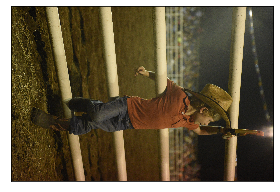

tensor([0])
tensor([[ 593.0031,  -16.3778,  -60.9254, -114.1479,  -95.6184, -154.5781,
          -64.2240,  -86.6917]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #21: tensor([[ 593.0031,  -16.3778,  -60.9254, -114.1479,  -95.6184, -154.5781,
          -64.2240,  -86.6917]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1564.5691,  -44.8168, -159.1535, -302.2397, -251.3318, -407.1851,
         -169.6119, -229.3405]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #22: tensor([[1564.5691,  -44.8168, -159.1535, -302.2397, -251.3318, -407.1851,
         -169.6119, -229.3405]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1687.4064,  -46.8058, -171.9376, -325.9675, -271.1951, -439.1109,
         -183.3094, -246.4907]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #23: tensor([[1687.4064,  -46.8058, -171.9376, -325.9675, -271.1951, -439.1109,
         -183.3094, -246.4907]], grad_fn=<AddmmBackward>)
tensor(

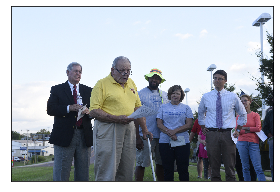

tensor([0])
tensor([[2155.7605,  -60.7605, -219.6281, -416.6898, -346.9582, -561.9036,
         -234.5144, -315.8161]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #41: tensor([[2155.7605,  -60.7605, -219.6281, -416.6898, -346.9582, -561.9036,
         -234.5144, -315.8161]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[3040.5156,  -85.2065, -309.2404, -586.9188, -489.0087, -791.7122,
         -330.0467, -446.1748]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #42: tensor([[3040.5156,  -85.2065, -309.2404, -586.9188, -489.0087, -791.7122,
         -330.0467, -446.1748]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1786.1871,  -50.5128, -182.1660, -344.9094, -287.6587, -465.7126,
         -194.4414, -262.8343]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #43: tensor([[1786.1871,  -50.5128, -182.1660, -344.9094, -287.6587, -465.7126,
         -194.4414, -262.8343]], grad_fn=<AddmmBackward>)
tensor(

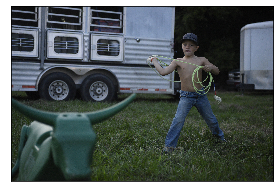

tensor([0])
tensor([[1863.1757,  -52.8577, -189.7822, -359.8781, -299.7742, -485.2612,
         -202.5582, -273.7281]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #61: tensor([[1863.1757,  -52.8577, -189.7822, -359.8781, -299.7742, -485.2612,
         -202.5582, -273.7281]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[2418.7263,  -67.4504, -246.2340, -467.2099, -389.6445, -629.9643,
         -263.2897, -355.0768]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #62: tensor([[2418.7263,  -67.4504, -246.2340, -467.2099, -389.6445, -629.9643,
         -263.2897, -355.0768]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 958.8795,  -27.2687,  -98.6586, -185.3402, -154.3449, -249.5988,
         -104.0794, -140.3790]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #63: tensor([[ 958.8795,  -27.2687,  -98.6586, -185.3402, -154.3449, -249.5988,
         -104.0794, -140.3790]], grad_fn=<AddmmBackward>)
tensor(

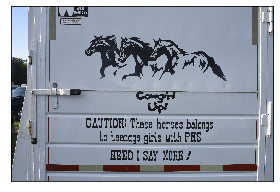

tensor([0])
tensor([[2711.2339,  -75.0382, -275.9018, -523.3740, -436.5139, -706.1198,
         -294.0623, -398.0019]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #81: tensor([[2711.2339,  -75.0382, -275.9018, -523.3740, -436.5139, -706.1198,
         -294.0623, -398.0019]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 7819.7847,  -220.6276,  -796.4179, -1510.3735, -1258.1990, -2036.5392,
          -850.1210, -1147.1140]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #82: tensor([[ 7819.7847,  -220.6276,  -796.4179, -1510.3735, -1258.1990, -2036.5392,
          -850.1210, -1147.1140]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1457.3975,  -41.0719, -147.9975, -281.0298, -234.1795, -379.6058,
         -158.7491, -213.4266]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #83: tensor([[1457.3975,  -41.0719, -147.9975, -281.0298, -234.1795, -379.6058,
         -158.7491, -213.4266]], grad_fn=<AddmmBa

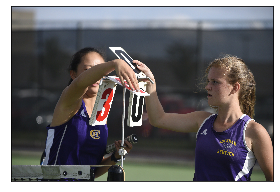

tensor([0])
tensor([[1018.6322,  -28.7605, -103.9614, -196.4683, -163.9381, -266.4616,
         -111.0562, -149.2404]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #101: tensor([[1018.6322,  -28.7605, -103.9614, -196.4683, -163.9381, -266.4616,
         -111.0562, -149.2404]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[2076.8452,  -58.5449, -211.4082, -400.8326, -335.1602, -540.7559,
         -225.8377, -304.3943]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #102: tensor([[2076.8452,  -58.5449, -211.4082, -400.8326, -335.1602, -540.7559,
         -225.8377, -304.3943]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1691.5911,  -46.8819, -171.8768, -326.4273, -272.4621, -440.7646,
         -183.6806, -248.0293]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #103: tensor([[1691.5911,  -46.8819, -171.8768, -326.4273, -272.4621, -440.7646,
         -183.6806, -248.0293]], grad_fn=<AddmmBackward>)
tens

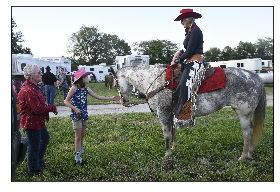

tensor([0])
tensor([[1165.2668,  -31.7652, -118.3456, -224.8409, -186.8802, -303.2427,
         -126.3169, -171.2421]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #121: tensor([[1165.2668,  -31.7652, -118.3456, -224.8409, -186.8802, -303.2427,
         -126.3169, -171.2421]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1923.9563,  -54.5723, -194.8091, -371.4319, -309.0779, -500.7542,
         -209.5424, -281.0895]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #122: tensor([[1923.9563,  -54.5723, -194.8091, -371.4319, -309.0779, -500.7542,
         -209.5424, -281.0895]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1934.4194,  -54.4272, -196.0915, -374.1436, -310.9566, -502.7078,
         -209.1461, -284.8990]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #123: tensor([[1934.4194,  -54.4272, -196.0915, -374.1436, -310.9566, -502.7078,
         -209.1461, -284.8990]], grad_fn=<AddmmBackward>)
tens

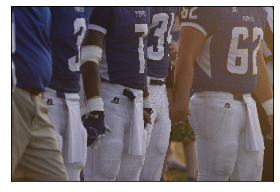

tensor([0])
tensor([[1085.1084,  -30.2872, -111.0817, -209.7016, -174.8024, -282.6420,
         -117.3639, -159.3105]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #141: tensor([[1085.1084,  -30.2872, -111.0817, -209.7016, -174.8024, -282.6420,
         -117.3639, -159.3105]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1671.3069,  -46.4931, -170.2031, -322.9960, -269.4994, -435.5988,
         -182.0161, -245.1434]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #142: tensor([[1671.3069,  -46.4931, -170.2031, -322.9960, -269.4994, -435.5988,
         -182.0161, -245.1434]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1350.8003,  -37.6166, -137.5202, -260.9764, -216.9919, -351.7742,
         -146.7130, -198.8587]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #143: tensor([[1350.8003,  -37.6166, -137.5202, -260.9764, -216.9919, -351.7742,
         -146.7130, -198.8587]], grad_fn=<AddmmBackward>)
tens

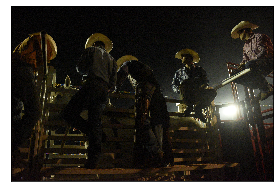

tensor([0])
tensor([[ 706.5983,  -19.9705,  -72.1702, -136.6880, -113.7624, -183.6696,
          -76.8444, -102.8850]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #161: tensor([[ 706.5983,  -19.9705,  -72.1702, -136.6880, -113.7624, -183.6696,
          -76.8444, -102.8850]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1068.6597,  -30.2627, -109.3654, -206.9378, -171.2680, -277.6682,
         -115.4814, -156.9255]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #162: tensor([[1068.6597,  -30.2627, -109.3654, -206.9378, -171.2680, -277.6682,
         -115.4814, -156.9255]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1999.9130,  -55.4511, -204.0889, -386.0974, -322.1815, -521.4283,
         -216.9337, -293.3040]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #163: tensor([[1999.9130,  -55.4511, -204.0889, -386.0974, -322.1815, -521.4283,
         -216.9337, -293.3040]], grad_fn=<AddmmBackward>)
tens

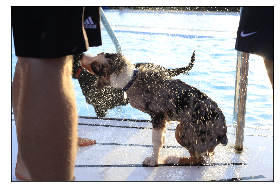

tensor([0])
tensor([[1372.4763,  -38.2185, -140.2319, -265.3959, -220.2240, -357.7043,
         -148.8391, -201.6917]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #181: tensor([[1372.4763,  -38.2185, -140.2319, -265.3959, -220.2240, -357.7043,
         -148.8391, -201.6917]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[1127.0668,  -31.9750, -114.9013, -216.7799, -182.3355, -293.5762,
         -122.8243, -166.1559]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #182: tensor([[1127.0668,  -31.9750, -114.9013, -216.7799, -182.3355, -293.5762,
         -122.8243, -166.1559]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[2272.9949,  -64.5368, -231.8851, -437.5539, -365.7177, -592.0654,
         -246.2839, -332.6293]], grad_fn=<AddmmBackward>) tensor([0])
Completed training output for image #183: tensor([[2272.9949,  -64.5368, -231.8851, -437.5539, -365.7177, -592.0654,
         -246.2839, -332.6293]], grad_fn=<AddmmBackward>)
tens

In [7]:
vgg16.train() # set model to training model
num_epochs = 1 
training_loss = 0
training_accuracy = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(train_loader,0):
        if limit_num_pictures:
            if i > limit_num_pictures:
                break
        inputs, _, path, label = data
        label = torch.LongTensor([int(label[0])])
        print(label)
        optimizer.zero_grad()
        output = vgg16(inputs)
        print(output, torch.LongTensor([int(label[0])]))
        loss = criterion(output, torch.LongTensor([int(label[0])]))
        running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        num_correct += (preds == label).sum().item()
        loss.backward()
        optimizer.step()
    

        print("Completed training output for image #{}: {}".format(i, output))
        if epoch == 0 and i % 20 == 0:
            fig = plt.figure(figsize=(16, 4))
            columns = 3
            rows = 1
            short_name = ''
            short_name.join(path[0].split('/')[8:])
            print(short_name)
            img = mpimg.imread(path[0])
            fig.add_subplot(rows, columns, 1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.show()
    training_loss = running_loss/len(train_loader.dataset)
    training_accuracy = 100 * num_correct/len(train_loader.dataset)
    print("Training accuracy: {}, Training loss: {}".format(training_accuracy, training_loss))

Below we validate our model on our test dataset. We are still calculating the loss and accuracy, but we are not backpropagating the gradients since backpropagation is only required during training. 


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_600.JPG
Classification for test image #0: [1427.1839599609375, -40.01750946044922, -145.27601623535156, -275.9255065917969, -229.87405395507812, -371.4693298339844, -155.08441162109375, -209.1385498046875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


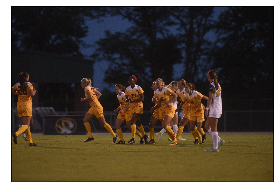


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0710.JPG
Classification for test image #1: [1124.791259765625, -31.667646408081055, -114.51508331298828, -216.81373596191406, -181.01556396484375, -293.04931640625, -122.21073913574219, -165.12164306640625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_084.JPG
Classification for test image #2: [1660.016357421875, -46.15672302246094, -169.1905517578125, -320.4349365234375, -267.46533203125, -432.3812561035156, -180.68174743652344, -243.26736450195312]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_116.JPG
Classification for test image #3: [1547.885986328125, -42.871582


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170902_districttrash_ec/20170902_DistrictlTrash_ec_061.JPG
Classification for test image #22: [1137.988037109375, -31.44481086730957, -116.04187774658203, -219.87393188476562, -183.99658203125, -297.294921875, -123.97926330566406, -166.86163330078125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0785.JPG
Classification for test image #23: [2141.4404296875, -59.818382263183594, -217.90536499023438, -413.4986877441406, -344.7327575683594, -557.8107299804688, -232.405517578125, -313.851318359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_1052.JPG
Classification for test image #24: [1194.101


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_Hickmanboyssoccer_ec/20170829_hickmansoccerboys_ec_620.JPG
Classification for test image #43: [1992.575439453125, -55.58906936645508, -202.94021606445312, -384.5904541015625, -320.09930419921875, -518.658447265625, -216.90350341796875, -292.4337158203125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170902_districttrash_ec/20170902_DistrictlTrash_ec_055.JPG
Classification for test image #44: [830.17041015625, -23.38429069519043, -84.06892395019531, -160.34828186035156, -133.4901123046875, -216.50669860839844, -90.19119262695312, -121.70545959472656]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0183.JPG
Classification for tes


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_705.JPG
Classification for test image #64: [1408.87744140625, -39.37522888183594, -143.46646118164062, -272.01519775390625, -226.79888916015625, -367.44390869140625, -153.50416564941406, -206.8514862060547]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0814.JPG
Classification for test image #65: [1745.632080078125, -48.99517822265625, -177.91424560546875, -337.6470642089844, -281.2242126464844, -455.13409423828125, -189.46710205078125, -255.9957275390625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_1187.JPG
Classification for test image #66: [1489.852905273


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_282.JPG
Classification for test image #85: [1234.952880859375, -34.586021423339844, -125.879150390625, -238.41543579101562, -198.6156005859375, -321.60223388671875, -133.9847869873047, -180.78518676757812]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_323.JPG
Classification for test image #86: [1155.8182373046875, -32.917388916015625, -117.75126647949219, -223.7104034423828, -185.6317596435547, -300.5975646972656, -125.792724609375, -169.61878967285156]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0560.JPG
Classification for test i


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170905_PouchPool_ec/20170905_poochplunge_EC_662.JPG
Classification for test image #106: [1896.5439453125, -53.14919662475586, -192.76373291015625, -366.1607971191406, -305.584716796875, -494.6634521484375, -206.27737426757812, -277.86737060546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0541.JPG
Classification for test image #107: [1534.65234375, -42.72428894042969, -156.1922149658203, -296.28082275390625, -247.13803100585938, -399.7386169433594, -167.16397094726562, -224.7681121826172]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0035.JPG
Classification for test image #108: [586.51800


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0758.JPG
Classification for test image #127: [1550.8173828125, -43.760536193847656, -157.73086547851562, -299.2608947753906, -249.8357391357422, -404.1548767089844, -168.47579956054688, -227.3203582763672]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170905_PouchPool_ec/20170905_poochplunge_EC_542.JPG
Classification for test image #128: [620.9147338867188, -17.259672164916992, -62.73492431640625, -119.76010131835938, -100.26103973388672, -162.18089294433594, -67.6667709350586, -91.22624206542969]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_244.JPG
Classification for test image #129: [959


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0341.JPG
Classification for test image #147: [1674.220458984375, -46.98680877685547, -170.39044189453125, -323.0393371582031, -269.21966552734375, -435.857666015625, -181.84478759765625, -245.6536865234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_1280.JPG
Classification for test image #148: [1245.975830078125, -34.5031623840332, -127.32400512695312, -241.16612243652344, -200.6759490966797, -324.4792785644531, -135.69387817382812, -182.5223846435547]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_180.JPG
Classification for test image #14


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_461.JPG
Classification for test image #168: [1039.36767578125, -29.305805206298828, -106.301025390625, -200.5623016357422, -167.108154296875, -270.701171875, -113.07205200195312, -152.2919921875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_441.JPG
Classification for test image #169: [1676.579345703125, -47.01679992675781, -170.82437133789062, -323.8025817871094, -269.5762023925781, -436.3042907714844, -182.24139404296875, -245.79632568359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_Hickmanboyssoccer_ec/20170829_hickmansoccerboys_ec_268.JPG
Classification for test image #170: [2353.163818359375


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_276.JPG
Classification for test image #189: [1212.430908203125, -33.9420166015625, -122.94696807861328, -234.09349060058594, -194.80859375, -315.7822265625, -131.8003692626953, -178.1296844482422]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0403.JPG
Classification for test image #190: [800.7996826171875, -22.07122230529785, -81.51292419433594, -154.71893310546875, -129.07205200195312, -208.49029541015625, -87.61515808105469, -117.52268981933594]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_758.JPG
Classification for test image #191: [1798.4844970703125, -50.717998


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0752.JPG
Classification for test image #210: [1408.6898193359375, -39.276912689208984, -143.75375366210938, -271.8711853027344, -226.68943786621094, -366.8476867675781, -152.9041290283203, -206.7784423828125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_440.JPG
Classification for test image #211: [1914.65771484375, -53.33729553222656, -195.06454467773438, -369.82611083984375, -307.906982421875, -498.4564208984375, -208.1983642578125, -280.3966064453125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0100.JPG
Classification for test image #212: [1836.156372070


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_737.JPG
Classification for test image #230: [1636.931884765625, -46.35753631591797, -166.4263916015625, -316.3032531738281, -263.219482421875, -426.48895263671875, -178.01742553710938, -240.04164123535156]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_061.JPG
Classification for test image #231: [1586.743896484375, -44.23170471191406, -161.4962921142578, -306.43609619140625, -255.4201202392578, -413.2597961425781, -172.48477172851562, -233.06935119628906]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_279.JPG
Classification for


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_266.JPG
Classification for test image #251: [883.9661254882812, -24.567750930786133, -89.6875, -170.82826232910156, -142.29344177246094, -230.66041564941406, -96.16564178466797, -129.2857666015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0940.JPG
Classification for test image #252: [764.8626708984375, -21.45844268798828, -78.17803192138672, -147.8196563720703, -122.66779327392578, -199.2825469970703, -83.42901611328125, -112.32518768310547]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_389.JPG
Classification for test image #253: [980.3707275390625, -2

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:97

In [8]:
# limit_num_pictures = 20
vgg16.eval() # set to prediction mode
testing_loss = 0
testing_accuracy = 0
running_loss = 0.0
num_correct = 0

ratings_data = None
for i, data in enumerate(test_loader, 0):
    
    if limit_num_pictures:
        if i > limit_num_pictures:
            break
    inputs, _, path, label = data
    path = path[0]
    label = torch.LongTensor([int(label[0])])

    output = vgg16(inputs)
    loss = criterion(output, label)

    running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    num_correct += (preds == label).sum().item()
    ratings = output[0].tolist()
    print("\nImage path: {}".format(path))
    print("Classification for test image #{}: {}".format(i, ratings))
    tuple_to_insert = {}
    for n in range(8):
        tuple_to_insert[str(n + 1)] = [ratings[n]]
    tuple_to_insert['file_path'] = [path]
    tuple_to_insert = pandas.DataFrame.from_dict(tuple_to_insert)

    if i == 0:
        ratings_data = tuple_to_insert
    else:
        ratings_data = ratings_data.append(tuple_to_insert, ignore_index=True)
    print(ratings_data.tail(0))
    if i % 2000 == 0:
        fig = plt.figure(figsize=(16, 4))
        columns = 3
        rows = 1
        img = mpimg.imread(path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

testing_loss = running_loss/len(test_loader.dataset)
testing_accuracy = 100. * num_correct/len(test_loader.dataset)
ratings_data = ratings_data.set_index('file_path')

In [9]:
ratings_data

,1,2,3,4,5,6,7,8,file_path
0,1427.183960,-40.017509,-145.276016,-275.925507,-229.874054,-371.469330,-155.084412,-209.138550,/mnt/md0/mysql-dump-economists/Archives/2017/F...
1,1124.791260,-31.667646,-114.515083,-216.813736,-181.015564,-293.049316,-122.210739,-165.121643,/mnt/md0/mysql-dump-economists/Archives/2017/F...
2,1660.016357,-46.156723,-169.190552,-320.434937,-267.465332,-432.381256,-180.681747,-243.267365,/mnt/md0/mysql-dump-economists/Archives/2017/F...
3,1547.885986,-42.871582,-157.675446,-298.796967,-248.966644,-403.180267,-168.156097,-226.658737,/mnt/md0/mysql-dump-economists/Archives/2017/F...
4,1046.637329,-28.881174,-106.495071,-202.459305,-167.859924,-272.871155,-114.071594,-153.570053,/mnt/md0/mysql-dump-economists/Archives/2017/F...
...,...,...,...,...,...,...,...,...,...
260,1807.849487,-51.011120,-183.960541,-349.363678,-291.130951,-470.763245,-196.098984,-265.263062,/mnt/md0/mysql-dump-economists/Archives/2017/F...
261,1779.397949,-49.727272,-180.989441,-344.242645,-286.621826,-463.905884,-193.604111,-260.974548,/mnt/md0/mysql-dump-economists/Archives/2017/F...
262,1237.301758,-34.510586,-125.921158,-239.022415,-198.838379,-321.896484,-134.248627,-181.266235,/mnt/md0/mysql-dump-economists/Archives/2017/F...
263,1516.926758,-42.263832,-154.277115,-292.784271,-243.777832,-394.977631,-165.085846,-222.374420,/mnt/md0/mysql-dump-economists/Archives/2017/F...


Choquet Integral

Once we have a pair of values we need to aggregate them together to get an overall ranking. We take the aesthetic and technical ranking derived from the network and determine a fuzzy measure to monitor for uncertainty.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
ratings_data_norm = pd.DataFrame(scaler.fit_transform(ratings_data), columns=ratings_data.columns, index=ratings_data.index)
ratings_data_norm.hist()
ratings_data.hist()

ValueError: could not convert string to float: '/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_600.JPG'

In [ ]:
ratings_data_norm['classification'] = ratings_data_norm.idxmax(axis=1)
ratings_data_norm

In [ ]:
ratings_data_norm = ratings_data_norm.sort_values(by=['classification'])
ratings_data_norm

In [ ]:
bad_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '8']
good_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '1']

In [ ]:
fig = plt.figure(figsize=(16, 4))
for path in good_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# fig = plt.figure(figsize=(16, 4))
for path in bad_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()